In [17]:
from PIL import Image
import torchvision.transforms as transforms
import torch

imageCityscapes = Image.open("photoCityscapes.png").convert("RGB") 
imageGTA = Image.open("photoGTA2.png").convert("RGB") 
imageCityscapes1 = Image.open("photoCityscapes2.png").convert("RGB") 
imageGTA1 = Image.open("photoGTA.png").convert("RGB") 

transform = transforms.Compose([
    transforms.Resize((512, 1024)),
    transforms.ToTensor(),
])
imageCityscapes_tensor = transform(imageCityscapes)
imageGTA_tensor = transform(imageGTA)
imageCityscapes_tensor = imageCityscapes_tensor.unsqueeze(0)
imageGTA_tensor = imageGTA_tensor.unsqueeze(0)

imageCityscapes_tensor1 = transform(imageCityscapes1)
imageGTA_tensor1 = transform(imageGTA1)
imageCityscapes_tensor1 = imageCityscapes_tensor1.unsqueeze(0)
imageGTA_tensor1 = imageGTA_tensor1.unsqueeze(0)


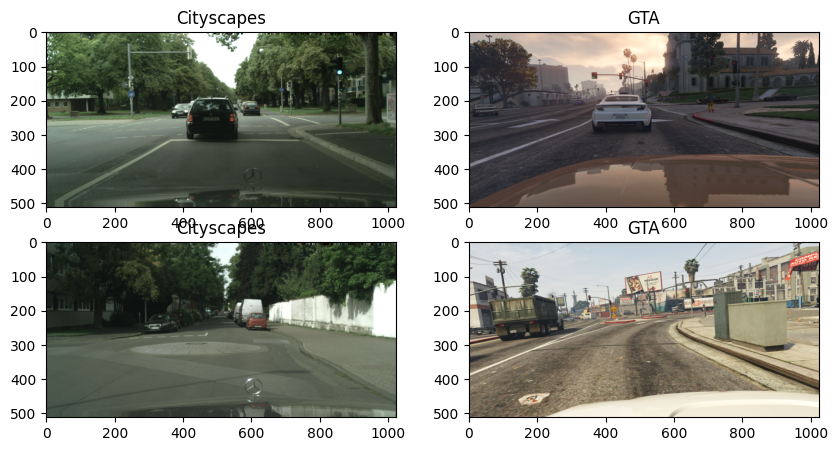

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax[0,0].imshow(imageCityscapes_tensor[0].permute(1, 2, 0))
ax[0,0].set_title("Cityscapes")
ax[0,1].imshow(imageGTA_tensor[0].permute(1, 2, 0))
ax[0,1].set_title("GTA")
ax[1,0].imshow(imageCityscapes_tensor1[0].permute(1, 2, 0))
ax[1,0].set_title("Cityscapes")
ax[1,1].imshow(imageGTA_tensor1[0].permute(1, 2, 0))
ax[1,1].set_title("GTA")
plt.show()

In [19]:
import random
import torch
import torchvision.transforms as TF
from torchvision.transforms import v2


def augment_data(img_tensor, augment = True, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    
    global device

    val = random.random()
    gaussian_blur = v2.GaussianBlur(5) #9, 2
    color_jitter = TF.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.5, hue=0.1) # 0.6, 0.6, 0.6, 0.1
    gaussian_noise = v2.GaussianNoise(mean=0.0, sigma=0.1)
    normalization = TF.Normalize(mean=mean, std=std)

    img_tensor = img_tensor

    val = 0
    if val < 0.5 and augment:
    # Geometric Transformations
        # Horizontal Flip
        # img_tensor = TF.functional.hflip(img_tensor)
        # target_color = np.fliplr(target_color).copy()
        # target_labelIds = np.fliplr(target_labelIds).copy()

    # Photometric Transformations
        # Gaussian Blur
        image = gaussian_blur(img_tensor)

        # Color Jitter
        img_tensor = color_jitter(img_tensor)

        # Gaussian Noise
        img_tensor = gaussian_noise(img_tensor)

        img_tensor = torch.clamp(img_tensor, 0.0, 1.0)
        # image = to_pil(img_tensor)

    # img_tensor = normalization(img_tensor)

    return img_tensor


def FDA(src_img: torch.Tensor, tgt_img: torch.Tensor, beta: float = 0.01, n: int = 1,
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) -> tuple[torch.Tensor, torch.Tensor]:
    """
    This functions applied the Fourier trasformation to the source domain
    with respect to the target domain
    Then to both the Tensor is applied data augmentation and normalization
    ATTENTION: for FDA it is necessary that both the images have the same high and width

    Inputs:
    - src_img: torch Tensor [B, 3, H, W ] from the source domain
    - tgt_img: torch Tensor [B//n, 3, H, W ] from the target domain
    - beta: coefficient for the mask of the FDA
    - n: ratio between the number of images of the batch of the source and target domain
    - mean, std: necessary for the normalization

    Outputs:
    - src_img_aug <- augmentation to src_img_fda <- FDA to src_img
    - tgt_img_aug <- augmentation to tgt_img

    """
    global device

    # FDA
    _, H, W = src_img.shape
    c_h, c_w = H // 2, W // 2
    bH = int(beta * H)
    bW = int(beta * W)

    fft_src = torch.fft.fft2(src_img, dim=(-2, -1))
    fft_tgt = torch.fft.fft2(tgt_img, dim=(-2, -1))

    fft_src_shift = torch.fft.fftshift(fft_src, dim=(-2, -1))
    fft_tgt_shift = torch.fft.fftshift(fft_tgt, dim=(-2, -1))

    mask = torch.zeros_like(fft_src).real
    mask[:, c_h - bH:c_h + bH, c_w - bW:c_w + bW] = 1
    mask = mask > 0.5

    amplitude_src = torch.abs(fft_src_shift)
    phase_src = torch.angle(fft_src_shift)
    amplitude_tgt = torch.abs(fft_tgt_shift)

    # fft_src = amplitude_src * exp(1j * phase_src)

    a = torch.fft.ifftshift(torch.where(mask, amplitude_tgt, amplitude_src)* torch.exp(1j * phase_src), dim=(-2, -1))
    src_img_fda = torch.fft.ifft2(a, dim=(-2, -1)).real.clamp(0, 1)

    # Data augmentation and normalization
    src_img_aug = augment_data(src_img_fda, augment=False, mean=mean, std=std)
    tgt_img_aug = augment_data(tgt_img, augment=False, mean=mean, std=std)

    return src_img_aug, tgt_img_aug

In [23]:
# Apply the FDA function
img_src, img_tgt = FDA(imageGTA_tensor[0], imageCityscapes_tensor[0], beta=0.01)
img_src1, img_tgt1 = FDA(imageGTA_tensor1[0], imageCityscapes_tensor1[0], beta=0.01)

img_src_bis, img_tgt_bis = FDA(imageGTA_tensor[0], imageCityscapes_tensor[0], beta=0.05)
img_src1_bis, img_tgt1_bis = FDA(imageGTA_tensor1[0], imageCityscapes_tensor1[0], beta=0.05)

img_src_tris, img_tgt_tris = FDA(imageGTA_tensor[0], imageCityscapes_tensor[0], beta=0.09)
img_src1_tris, img_tgt1_tris = FDA(imageGTA_tensor1[0], imageCityscapes_tensor1[0], beta=0.09)

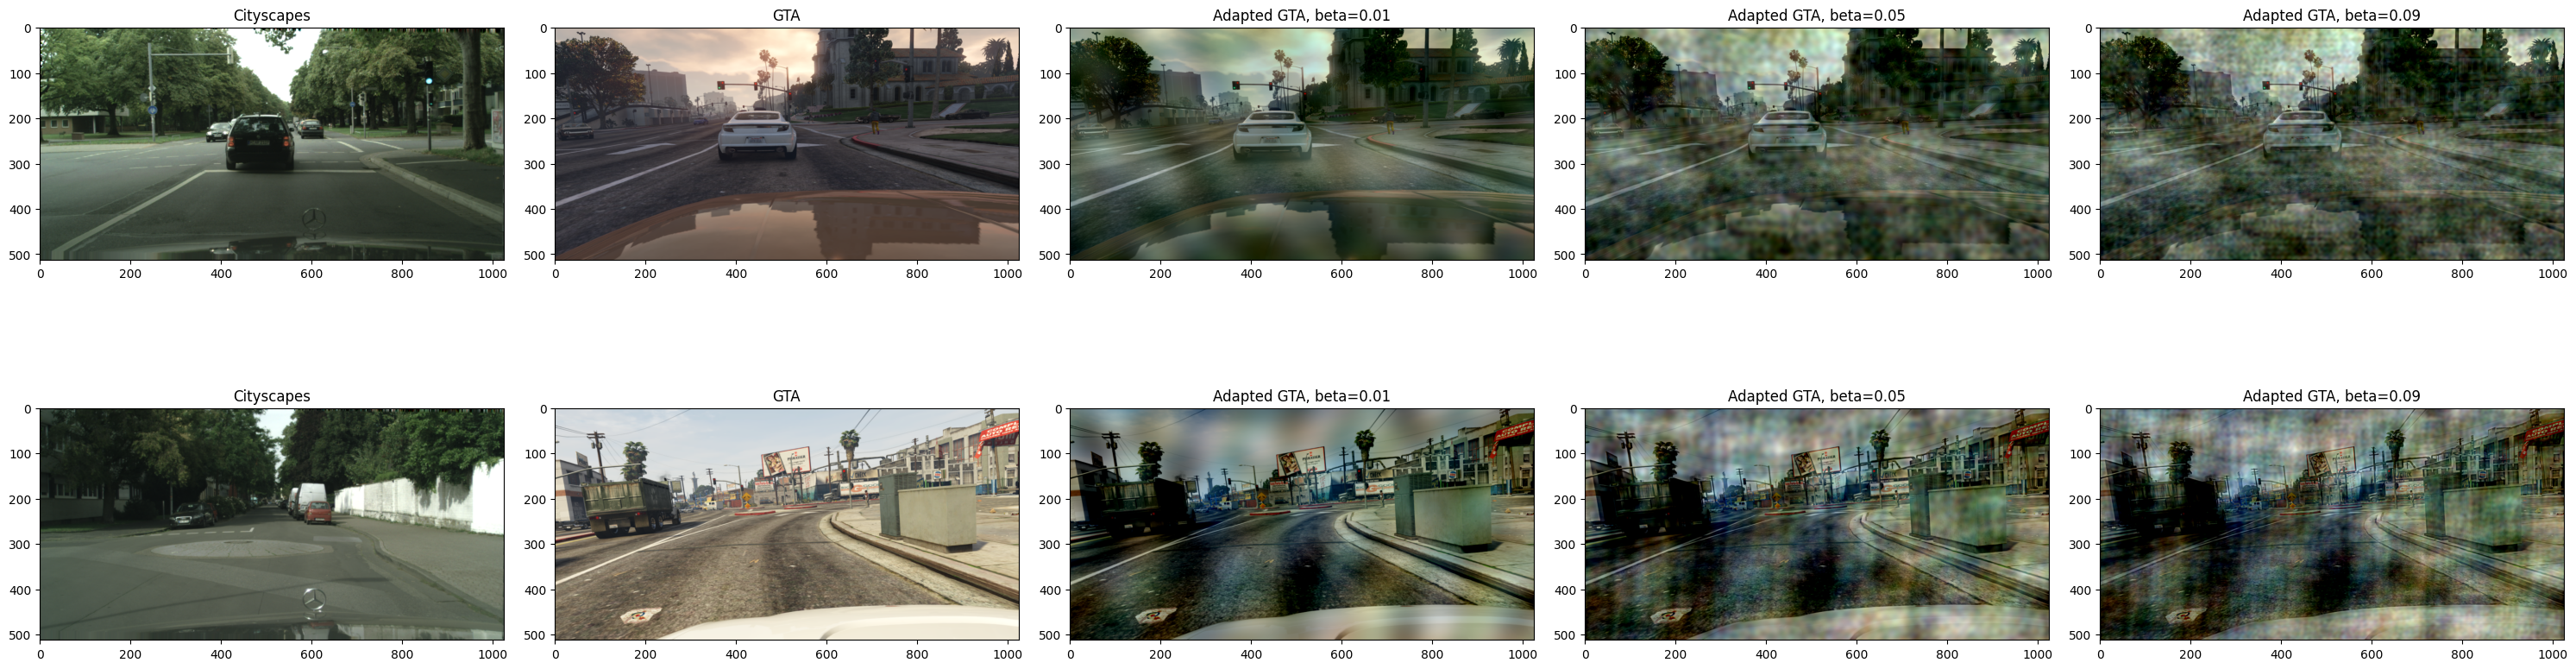

In [25]:
fig, ax = plt.subplots(2,5, figsize=(30, 10))
ax[0,0].imshow(imageCityscapes_tensor[0].permute(1, 2, 0))
ax[0,0].set_title("Cityscapes")
ax[0,1].imshow(imageGTA_tensor[0].permute(1, 2, 0))
ax[0,1].set_title("GTA")
ax[0,2].imshow(img_src.permute(1, 2, 0))
ax[0,2].set_title("Adapted GTA, beta=0.01")
ax[0,3].imshow(img_src_bis.permute(1, 2, 0))
ax[0,3].set_title("Adapted GTA, beta=0.05")
ax[0,4].imshow(img_src_tris.permute(1, 2, 0))
ax[0,4].set_title("Adapted GTA, beta=0.09")
ax[1,0].imshow(imageCityscapes_tensor1[0].permute(1, 2, 0))
ax[1,0].set_title("Cityscapes")
ax[1,1].imshow(imageGTA_tensor1[0].permute(1, 2, 0))
ax[1,1].set_title("GTA")
ax[1,2].imshow(img_src1.permute(1, 2, 0))
ax[1,2].set_title("Adapted GTA, beta=0.01")
ax[1,3].imshow(img_src1_bis.permute(1, 2, 0))
ax[1,3].set_title("Adapted GTA, beta=0.05")
ax[1,4].imshow(img_src1_tris.permute(1, 2, 0))
ax[1,4].set_title("Adapted GTA, beta=0.09")
plt.tight_layout()
plt.show()